In [92]:
import torch as t, torch.nn as nn
import torchvision as tv, torchvision.transforms as tfm
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
import sys
import math

img_size, batch_size = 32, 100
nz, nc, ndf, ngf = (
    100,
    3,
    200,
    64,
)  # latent z dim., channel dim., hidden feature dim., image dim.?
K_0, a_0, K_1, a_1 = 60, 0.4, 40, 0.1  # Each Langevin steps and sqrt(step size)s
llhd_sigma = 0.3  # assumed value for standard deviation of log likelihood
n_iter = 1000  # number of iterations
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [93]:
## Class_G Module
# input: Latent Space (100,100,1,1) / output: RGB Img Kernels (100,3,32,32)
class _G(nn.Module):
    def __init__(self):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(
                nz, ngf * 8, kernel_size=4, stride=1, padding=0
            ),  # 100 to 64*8
            nn.LeakyReLU(),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1),  # 64*2 to 3(RGB?)
            nn.Tanh(),
        )

    def forward(self, z):
        return self.gen(z)  ## Top-down Generator, compressed latent -> RGB

In [94]:
## Class_E Module
# input: Latent Space (100,100,1,1) / output: Scalar Energy (100,1,1,1)
class _E(nn.Module):
    def __init__(self):
        super().__init__()
        self.ebm = nn.Sequential(
            nn.Linear(nz, ndf),  # 100 to 200(hidden feature)
            nn.LeakyReLU(0.2),
            nn.Linear(ndf, ndf),
            nn.LeakyReLU(0.2),
            nn.Linear(ndf, 1),  # Scalar energy value
        )

    def forward(self, z):
        return self.ebm(z.squeeze()).view(
            -1, 1, 1, 1
        )  # squeezing, reconstructing to 4 dimensions

In [95]:
## optE, optG
# input: / output:
transform = tfm.Compose(
    [
        tfm.Resize(img_size),  # resize smaller edge of img to 32(img_size)
        tfm.ToTensor(),  # (C,W,H) with 0.0-1.0 real number
        tfm.Normalize(
            mean=([0.5] * 3), std=([0.5] * 3)
        ),  # [0.0-1.0] to normalized [-1.0,+1.0] for _G's nn.Tanh()
    ]
)
data = t.stack(
    [
        x[0]
        for x in tv.datasets.SVHN(root="data/svhn", transform=transform, download=True)
    ]
).to(
    device
)  # tensor of imgs, without labels

G, E = _G().to(device), _E().to(device)
mse = nn.MSELoss(reduction="sum")  # returns summation of losses
optE = t.optim.Adam(
    E.parameters(), lr=0.00002, betas=(0.5, 0.999)
)  # using Adam Optimizer to backward step
optG = t.optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [96]:
## sampling
# input: / output:
def sample_p_data():  # randomly samples 100 data from 100 indices, without autograd
    return data[t.LongTensor(batch_size).random_(0, data.size(0))].detach()


def sample_p_0(n=batch_size):  # P0(z) ~ N(0,I). Sampling base priors
    return t.randn(*[n, nz, 1, 1]).to(device)  # (100*100*1*1)


def sample_langevin_prior(z, E):  # MCMC sampling for prior distribution
    z = z.clone().detach().requires_grad_(True)  # initializes gradients
    for i in range(K_0):
        en = E(z)  # forward. en is (100,1,1,1)
        z_grad = t.autograd.grad(en.sum(), z)[
            0
        ]  # uses gradient of summation of energy,
        # [0] for extracting gradient from tuple form
        z.data = z.data - 0.5 * a_0 * a_0 * (z_grad + 1e-5) + a_0 * t.randn_like(z).data
        # Equation (9) on the paper. slightly decrease multipliers for prohibiting noise flooding
    return z.detach()


def sample_langevin_posterior(z, x, G, E):  # MCMC sampling for posterior distribution
    # z is latent space, x is img itself, G and E are Modules.
    z = z.clone().detach().requires_grad_(True)  # initializes gradients
    for i in range(K_1):

        x_hat = G(z)  # forward. x_hat is (100,3,32,32)

        g_log_lkhd = (
            1.0 / (2.0 * llhd_sigma * llhd_sigma) * mse(x_hat, x)
        )  # -logP(x|z), ignore the constant
        grad_g = t.autograd.grad(g_log_lkhd, z)[
            0
        ]  # gradient of g_log_lkhd, dimemsion is (100,100,1,1)

        en = E(z)  # forward. en is (100,1,1,1)
        grad_e = t.autograd.grad(en.sum(), z)[
            0
        ]  # uses gradient of summation of energy,
        # [0] for extracting gradient from tuple form
        z.data = (
            z.data
            - 0.5 * a_1 * a_1 * (grad_g + grad_e + 1.0 / z.data)
            + a_1 * t.randn_like(z).data
        )
        # Equation (9) on the paper.
    return z.detach()

In [97]:
reses = []


def eval():
    # sample one z
    z_init = t.randn(100, 100, 1, 1).to(device)
    x = sample_p_data()
    z_test = sample_langevin_posterior(z_init, x, G, E)

    # get x_hat
    x_hat = G(z_test)

    # MSE compare
    res = mse(x_hat, x)

    reses.append(res.cpu().detach().numpy())

In [98]:
## step and backward

# progress bar
sys.stdout.write(f"\rProgress: [[{' ' * 50} 0%]]")
sys.stdout.flush()

# input: / output:
for i in range(n_iter):
    # for i in range(n_iter):
    x = sample_p_data()  # x is img itself. the batch x is (100,3,32,32).
    z_e_0, z_g_0 = (
        sample_p_0(),
        sample_p_0(),
    )  # initial distribution comes from Gaussian noise
    z_e_k, z_g_k = sample_langevin_prior(z_e_0, E), sample_langevin_posterior(
        z_g_0, x, G, E
    )
    # short-run Langevin MCMC for prior and posterior distributions

    optG.zero_grad()
    x_hat = G(z_g_k.detach())
    # print(x.shape)
    # print(x_hat.shape)
    loss_g = mse(x_hat, x) / batch_size  # Equation (11)
    loss_g.backward()
    optG.step()  # update optimizer for Generator

    optE.zero_grad()
    en_pos, en_neg = E(z_g_k.detach()).mean(), E(z_e_k.detach()).mean()
    loss_e = en_pos - en_neg  # Equation (10)
    loss_e.backward()
    optE.step()  # update optimizer for EBM

    # increment progress bar
    percentage = round(((i + 1) / n_iter) * 100, 1)
    sys.stdout.write(
        f"\rProgress: [[{'#' *  math.floor(percentage/2)}{' ' * (50 - math.floor(percentage/2))} {percentage}%]]"
    )
    sys.stdout.flush()
    eval()

print("Done")

Progress: [[################################################## 100.0%]]Done


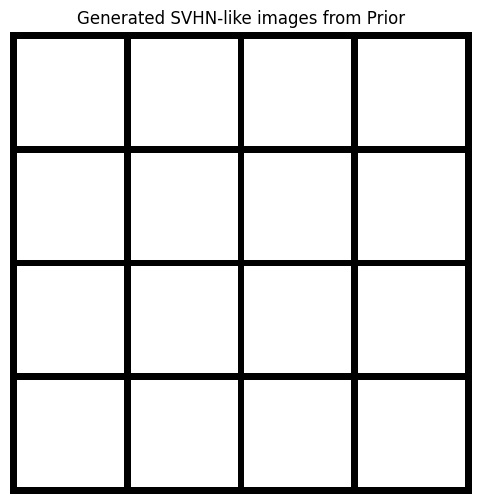

In [99]:
z_init = t.randn(16, 100, 1, 1).to(device)

# 2. Langevin dynamics using prior energy model E
z_refined = sample_langevin_prior(z_init, E)  # output: (16, 100, 1, 1)

# 3. 생성 이미지 얻기
x_gen = G(z_refined).detach().cpu()  # output: (16, 3, 32, 32)

# 4. 시각화
grid = make_grid(x_gen, nrow=4, normalize=True)
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.title("Generated SVHN-like images from Prior")
plt.show()

In [100]:
# with t.no_grad():
#     z_test = sample_p_data()
#     # x_test = G(z_test).detach().cpu()
#     grid = make_grid(z_test[:25], nrow=5, normalize=True)
#     plt.imshow(grid.permute(1, 2, 0))
#     plt.title("Test Decoder Output")
#     plt.show()

# Test Eval

In [101]:
reses = np.nan_to_num(np.array(reses))
print(reses)

[54258.027 55784.406 54151.562 49633.914 51653.42  54673.84  52072.617
 52581.824 59309.055 57239.945 49049.88  54160.508 49018.32  42631.26
 52443.203 50676.617 51862.16  48426.41  52441.58  53264.555 54780.016
 55442.63  50991.797 51241.867 56942.    54804.145 50489.773 50213.047
 53440.594 52177.54  55662.95  54962.324 50722.836 51208.887 58805.574
 52506.664 51600.848 52550.31  55443.008 51842.258 50233.53  49563.14
 52414.727 47702.51  46770.4   40519.65  55997.695 55436.64  47796.58
 52389.64  52827.78  53232.57  41514.562 50464.35  46507.805 49405.164
 55433.89  46078.586 44694.977 51268.39  48607.164 50157.344 48686.42
 56194.426 54792.547 53116.56  56069.125 47680.453 46395.406 52270.094
 51300.727 47474.72  47431.87  59769.906 48875.633 51310.44  44555.33
 55933.984 48089.42  52153.766 50441.69  49894.58  43417.4   48357.203
 53539.69  51873.484 54777.36  57655.242 41265.633 46418.44  47105.375
 50233.598 42667.13  50095.742 46954.297 49314.277 52886.863 54401.324
 51606.86  

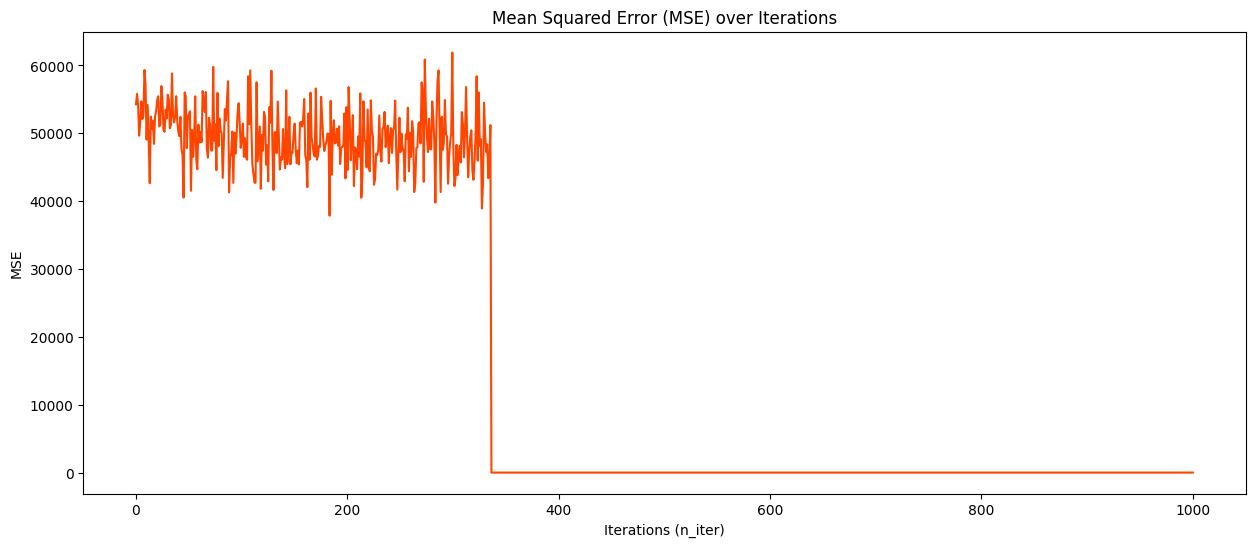

In [102]:

plt.figure(figsize=(15, 6))
plt.plot(np.linspace(0, n_iter, n_iter), reses, c="orangered")
plt.xlabel("Iterations (n_iter)")
plt.ylabel("MSE")
plt.title("Mean Squared Error (MSE) over Iterations")

plt.show()

# Results
Partial/most successful results have been included as attachments under *./Results/*